In [3]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

In [19]:
import pandas as pd
import SimpleITK as sitk
from matplotlib import pyplot as plt
import numpy as np

# Description

The ACUSLIC dataset consists of:
- 300 cases ("3D" US volumes) for **Training**
    - 281 subjects. Some subjects have multiple volumes.
- 10 cases for **Validation** (not available)
- 290 cases for **Testing** (not available)

## Images
The 3D volume consists of six sweeps over the gravid abdomen:<br>
<img src="https://rumc-gcorg-p-public.s3.amazonaws.com/i/2024/04/20/image_c5bQhgg.png" width="150">

As such the 3D volumne is a concatanation of 6 sweeps, and in turn the sweeps are 2D B-mode ultrasound sweep data.

Characteristics:
- Number of frames in total: 840
- Number of frames per sweep: ~between 100-125 (changes)
- Slice size: 744x562
- Spacing: 0.28 mm/pixel

## Masks and measurements

The masks represent annotation of an optimal or suboptimal plane for abdominal circumference measurement.<br>
The masks were drawn per slice.<br>
- Pixel of background are labeled as 0
- Pixels correponding to the optimal plane are labeled as 1
- Pixels corresponding to the suboptimal plane are labeled as 2

Abdominal circumference reference values (mm) are also available.
- For both optimal and suboptimal planes.
- Available per sweep.


In [5]:
# confirm we have 300 images in the folder
im_dir = repo_path / 'data/original/images/stacked_fetal_ultrasound'
mask_dir = repo_path / 'data/original/masks/stacked_fetal_abdomen'
# count files
im_files = os.listdir(im_dir)
mask_files = os.listdir(mask_dir)
print(f'The number of images in the folder is {len(im_files)} and the number of masks is {len(mask_files)}')

The number of images in the folder is 300 and the number of masks is 300


# Visualization example

In [6]:
# use circunference mesuarement csv to load cases
meta_path = repo_path / 'data/original/circumferences/fetal_abdominal_circumferences_per_sweep.csv'
metadata = pd.read_csv(meta_path)

In [7]:
# get example
ex_row = metadata.iloc[0]
im_path = im_dir / f'{ex_row["uuid"]}.mha'
mask_path = mask_dir / f'{ex_row["uuid"]}.mha'
assert im_path.exists() and mask_path.exists(), 'The example does not exist'

im = sitk.ReadImage(str(im_path))
mask = sitk.ReadImage(str(mask_path))
im_array = sitk.GetArrayFromImage(im)
mask_array = sitk.GetArrayFromImage(mask)


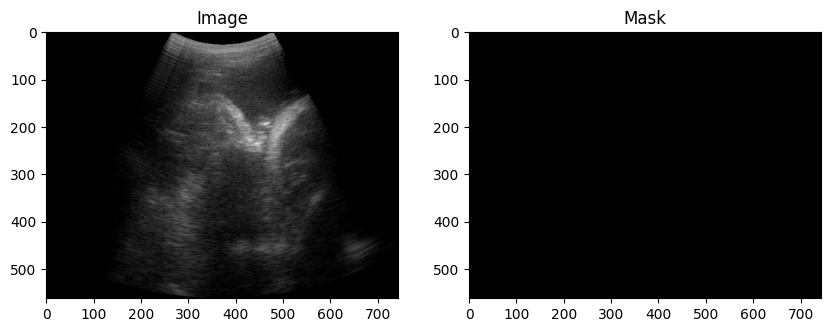

In [8]:
slice_num = 200
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(im_array[slice_num], cmap='gray')
axs[0].set_title('Image')
axs[1].imshow(mask_array[slice_num], cmap='gray')
axs[1].set_title('Mask')
plt.show()

# Create extended metadata

In [51]:
# using the circumference mesuarement csv as baseline
meta_path = repo_path / 'data/original/circumferences/fetal_abdominal_circumferences_per_sweep.csv'
metadata = pd.read_csv(meta_path)
# directories
mask_dir = 'data/original/masks/stacked_fetal_abdomen'

# new columns 'z_values_opt' and 'z_values_subopt'
metadata['z_values_opt'] = None
metadata['z_values_subopt'] = None
metadata

,uuid,subject_id,sweep_1_ac_mm,sweep_2_ac_mm,sweep_3_ac_mm,sweep_4_ac_mm,sweep_5_ac_mm,sweep_6_ac_mm,z_values_opt,z_values_subopt
0,2e99ee0e-506a-443b-8c16-e8a0619da2f7,0,579.217706,NaN,NaN,NaN,NaN,NaN,None,None
1,bfd442e7-9299-4890-ad3d-c9d5b6534cbc,1,NaN,NaN,NaN,NaN,519.406363,NaN,None,None
2,0199616b-bdeb-4119-97a3-a5a3571bd641,2,624.540028,NaN,NaN,NaN,587.598341,NaN,None,None
3,dcdcb9a4-fec7-45a2-b2b7-a282f963c551,2,398.869800,NaN,NaN,NaN,NaN,NaN,None,None
4,484c03b0-441d-4966-b10e-06b31d84e55e,3,614.922733,NaN,NaN,NaN,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...
295,b48630a1-6dd5-4961-82f4-9eabb90f5db2,276,366.501124,389.592909,356.839282,NaN,NaN,NaN,None,None
296,ba6acb2e-8a8f-4a21-a986-ee1c2a1d41fc,277,441.227784,NaN,NaN,NaN,NaN,NaN,None,None
297,5bdd3202-3eac-417c-856b-c642ee0aabdf,278,543.841799,523.070533,559.070212,NaN,NaN,NaN,None,None
298,740e57a6-d368-48d2-a3ec-fae51776757b,279,362.403863,NaN,366.319778,NaN,NaN,NaN,None,None


In [52]:
# read the first row
ex_row = metadata.iloc[0].copy()
mask_path = repo_path / mask_dir / f'{ex_row["uuid"]}.mha'
assert mask_path.exists(), 'The example does not exist'
# read mask
mask = sitk.ReadImage(str(mask_path))
mask_array = sitk.GetArrayFromImage(mask)
# get frames where mask is not empty
z_values_opt = np.unique(np.where(mask_array==1)[0])
z_values_subopt = np.unique(np.where(mask_array==2)[0])
# add columns to the series
ex_row['z_values_opt'] = len(z_values_opt)
ex_row['z_values_subopt'] = len(z_values_subopt)

In [53]:
# send row back to the dataframe
metadata.iloc[0] = ex_row
metadata

,uuid,subject_id,sweep_1_ac_mm,sweep_2_ac_mm,sweep_3_ac_mm,sweep_4_ac_mm,sweep_5_ac_mm,sweep_6_ac_mm,z_values_opt,z_values_subopt
0,2e99ee0e-506a-443b-8c16-e8a0619da2f7,0,579.217706,NaN,NaN,NaN,NaN,NaN,6,3
1,bfd442e7-9299-4890-ad3d-c9d5b6534cbc,1,NaN,NaN,NaN,NaN,519.406363,NaN,None,None
2,0199616b-bdeb-4119-97a3-a5a3571bd641,2,624.540028,NaN,NaN,NaN,587.598341,NaN,None,None
3,dcdcb9a4-fec7-45a2-b2b7-a282f963c551,2,398.869800,NaN,NaN,NaN,NaN,NaN,None,None
4,484c03b0-441d-4966-b10e-06b31d84e55e,3,614.922733,NaN,NaN,NaN,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...
295,b48630a1-6dd5-4961-82f4-9eabb90f5db2,276,366.501124,389.592909,356.839282,NaN,NaN,NaN,None,None
296,ba6acb2e-8a8f-4a21-a986-ee1c2a1d41fc,277,441.227784,NaN,NaN,NaN,NaN,NaN,None,None
297,5bdd3202-3eac-417c-856b-c642ee0aabdf,278,543.841799,523.070533,559.070212,NaN,NaN,NaN,None,None
298,740e57a6-d368-48d2-a3ec-fae51776757b,279,362.403863,NaN,366.319778,NaN,NaN,NaN,None,None
